# Forecasting Rental Prices in Kensington, SA
### Scope:
#### - Evaluate the time series evolution of property rentals in my neighbourhood (Kensington, PC 5068).
#### - Use this information to create a model that will forecast future rental prices.

Data source: https://data.sa.gov.au/data/dataset/private-rent-report


## Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import itertools
from glob import glob
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Styling

plt.style.use('fivethirtyeight')
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
mpl.rcParams.update(params)

## Load and explore the data

In [2]:
#Create an iterable for different combinations of filenames
filenames_csv_2012_09_to_2019_06 = glob('private-rental-report-postcode-*.csv')

#Create a list of dataframes
dataframes_list_raw_2012_09_to_2019_06 = [pd.read_csv(f) for f in filenames_csv_2012_09_to_2019_06]

#Explore the data
dataframes_list_raw_2012_09_to_2019_06[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 31 columns):
Quarterperiodend          278 non-null object
metro_restofstate         278 non-null object
postcode                  278 non-null object
1BR_flats_count           278 non-null object
1BR_flats_median$         97 non-null float64
2BR_flats_count           278 non-null object
2BR_flats_median$         156 non-null float64
3BR_flats_count           278 non-null object
3BR_flats_median$         128 non-null float64
4+BR_flats_count          278 non-null object
4+BR_flats_median$        29 non-null float64
flats_unknown_count       278 non-null object
flats_unknown_median$     139 non-null float64
total_flats_count         278 non-null object
total_flats_median$       178 non-null float64
1BR_houses_count          278 non-null object
1BR_houses_median$        72 non-null float64
2BR_houses_count          278 non-null object
2BR_houses_median$        170 non-null float64
3BR_houses_count

In [3]:
dataframes_list_raw_2012_09_to_2019_06[0].head()

,Quarterperiodend,metro_restofstate,postcode,1BR_flats_count,1BR_flats_median$,2BR_flats_count,2BR_flats_median$,3BR_flats_count,3BR_flats_median$,4+BR_flats_count,...,4+BR_houses_count,4+BR_houses_median$,houses_unknown_count,houses_unknown_median$,total_houses_count,total_houses_median$,total_other_count,total_other_median$,total_all_count,total_all_median$
0,2012-09,Metro,5000,174,275.0,186,400.0,36,498.0,*,...,*,700.0,31,430.0,100,410.0,55,195.0,665,340.0
1,2012-09,Metro,5006,17,295.0,31,330.0,6,380.0,*,...,*,650.0,14,407.5,50,440.0,0,NaN,130,365.0
2,2012-09,Metro,5007,0,NaN,8,277.5,*,360.0,0,...,*,350.0,17,330.0,60,350.0,0,NaN,85,340.0
3,2012-09,Metro,5008,0,NaN,22,240.0,*,350.0,0,...,6,370.0,39,325.0,95,330.0,*,140.0,140,300.0
4,2012-09,Metro,5009,0,NaN,*,277.5,0,NaN,0,...,0,NaN,16,330.0,40,320.0,0,NaN,45,315.0


#### Description

These datasets provide information of rental prices in South Australia. This data is captured when rental bonds are set as per the State guidelines.

From the source: "Summary of median private rent in South Australia by: suburb, postcode, State Government regions and Local Government Areas. The information relates to bonds lodged with Consumer and Business Services for private rental properties in South Australia."

• Considering the scope of the project, the following columns will be used: ['Quarterperiodend', 'postcode', 'total_all_median$']

• There are two different type of data source, the first one from 09/2012 to 06/2019 and the second one from 09/2019 to 06/2020. These will be prepared below.

## Data pre-processing

In [4]:
# Concatenate everything in one Dataframe

dataframe_raw_2012_09_to_2019_06 = pd.concat(dataframes_list_raw_2012_09_to_2019_06, axis=0, ignore_index=True)
dataframe_raw_2012_09_to_2019_06.head()

,Quarterperiodend,metro_restofstate,postcode,1BR_flats_count,1BR_flats_median$,2BR_flats_count,2BR_flats_median$,3BR_flats_count,3BR_flats_median$,4+BR_flats_count,...,4+BR_houses_count,4+BR_houses_median$,houses_unknown_count,houses_unknown_median$,total_houses_count,total_houses_median$,total_other_count,total_other_median$,total_all_count,total_all_median$
0,2012-09,Metro,5000,174,275.0,186,400.0,36,498.0,*,...,*,700.0,31,430.0,100,410.0,55,195.0,665,340.0
1,2012-09,Metro,5006,17,295.0,31,330.0,6,380.0,*,...,*,650.0,14,407.5,50,440.0,0,NaN,130,365.0
2,2012-09,Metro,5007,0,NaN,8,277.5,*,360.0,0,...,*,350.0,17,330.0,60,350.0,0,NaN,85,340.0
3,2012-09,Metro,5008,0,NaN,22,240.0,*,350.0,0,...,6,370.0,39,325.0,95,330.0,*,140.0,140,300.0
4,2012-09,Metro,5009,0,NaN,*,277.5,0,NaN,0,...,0,NaN,16,330.0,40,320.0,0,NaN,45,315.0


In [5]:
#Selecting columns
columns_selected = ['Quarterperiodend', 'postcode', 'total_all_median$']
df_columns_raw_2012_09_to_2019_06 = dataframe_raw_2012_09_to_2019_06[columns_selected]
df_columns_raw_2012_09_to_2019_06.head()

,Quarterperiodend,postcode,total_all_median$
0,2012-09,5000,340.0
1,2012-09,5006,365.0
2,2012-09,5007,340.0
3,2012-09,5008,300.0
4,2012-09,5009,315.0


In [6]:
# Selecting Kensington results: PC == 5068

kensington_raw_2012_09_to_2019_06 = df_columns_raw_2012_09_to_2019_06[df_columns_raw_2012_09_to_2019_06['postcode'] == '5068']
kensington_raw_2012_09_to_2019_06.head()

,Quarterperiodend,postcode,total_all_median$
49,2012-09,5068,330.0
327,2012-12,5068,320.0
603,2013-03,5068,332.5
874,2013-06,5068,325.0
1159,2013-09,5068,320.0


In [7]:
# Now we have to process the other data from 2019-06 to 2020-06.
# This data is in heavily formatted Excel files and need some pre-processing before I can import them here.
# Format and instructions will be removed on the 4 files, and the information will be summarized in the target columns per period and PC.

kensington_raw_2019_09_to_2020_06 = pd.read_excel('private-rental-report-2019-09-2020-06.xlsx')
kensington_raw_2019_09_to_2020_06.head()


,Quarterperiodend,postcode,total_all_median$
0,2019-09,5068,350
1,2019-12,5068,365
2,2020-03,5068,350
3,2020-06,5068,355


In [8]:
#We concatenate both Dataframes
concat_this = [kensington_raw_2012_09_to_2019_06, kensington_raw_2019_09_to_2020_06]
kensington_2012_09_to_2020_06 = pd.concat(concat_this, axis=0, ignore_index=True)
kensington_2012_09_to_2020_06.head()

,Quarterperiodend,postcode,total_all_median$
0,2012-09,5068,330.0
1,2012-12,5068,320.0
2,2013-03,5068,332.5
3,2013-06,5068,325.0
4,2013-09,5068,320.0


## Time Series dataframe

In [9]:
# Lets create the time series, rename columns and drop post code.
data = kensington_2012_09_to_2020_06.copy()

data.drop(columns='postcode', inplace=True)

data.columns = ['Quarter_End', 'Kensington_Rental_Median']

data.index = pd.date_range('2012-09-01', freq='Q', periods=len(data))

data.index.name = 'Quarter_End'

#data.index = pd.to_datetime(data['Quarter_End'])
#data = data.asfreq(freq='Q', method='ffill')

data.drop(columns='Quarter_End', inplace=True)

data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2012-09-30 to 2020-06-30
Freq: Q-DEC
Data columns (total 1 columns):
Kensington_Rental_Median    32 non-null float64
dtypes: float64(1)
memory usage: 512.0 bytes


,Kensington_Rental_Median
Quarter_End,
2012-09-30,330.0
2012-12-31,320.0
2013-03-31,332.5
2013-06-30,325.0
2013-09-30,320.0
2013-12-31,315.0
2014-03-31,322.5
2014-06-30,325.0
2014-09-30,330.0


## Visualizing the time series

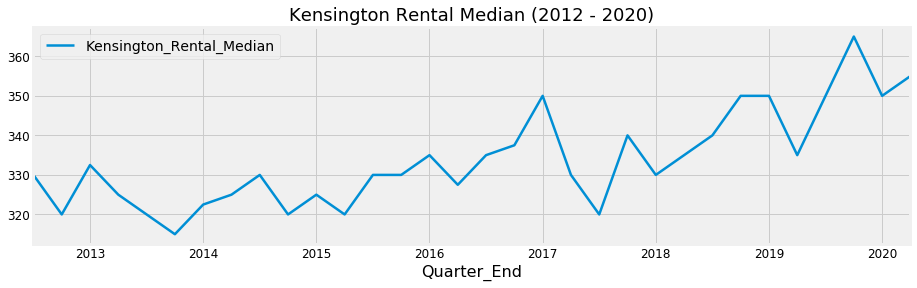

In [33]:
data.plot(figsize=(14,4))
plt.title('Kensington Rental Median (2012 - 2020)')
plt.show()

##### Data visualization comments:
• The data presents an increasing trend and may present certain seasonability.

• I cannot make comments at this stage regaridng its variance.

• The data is non-stationary.

## Method and Model selection - ARIMA and Box-Jenkins
To forecast rental prices in Kensington I will use an ARIMA model, which may include seasonality.
I will use the Box-Jenkins method to find a good model to explain and forecast the data.


## Identification

In [11]:
adf_data = adfuller(data['Kensington_Rental_Median'])
print(adf_data)
print('ADF Statistic:', adf_data[0])
print('p-value for ADF Test:', adf_data[1])
print('We can not reject the null hypothesis with a 95% confidence. As expected, the data is non-stationary.')
print('The data will require some kind of trasnformation in order of applying an ARIMA mdoel.')

(-2.1124072124442295, 0.23955495483167977, 0, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 158.67107390054252)
ADF Statistic: -2.1124072124442295
p-value for ADF Test: 0.23955495483167977
We can not reject the null hypothesis with a 95% confidence. As expected, the data is non-stationary.
The data will require some kind of trasnformation in order of applying an ARIMA mdoel.


In [12]:
adf_data_diff = adfuller(data['Kensington_Rental_Median'].diff().dropna())
print(adf_data_diff)
print('ADF Statistic:', adf_data_diff[0])
print('p-value for ADF Test:', adf_data_diff[1])
print('I reject the null hypothesis with more than a 95% confidence. The data is stationary.')

(-5.303787493014887, 5.377598571823774e-06, 2, 28, {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}, 157.08998201691185)
ADF Statistic: -5.303787493014887
p-value for ADF Test: 5.377598571823774e-06
I reject the null hypothesis with more than a 95% confidence. The data is stationary.


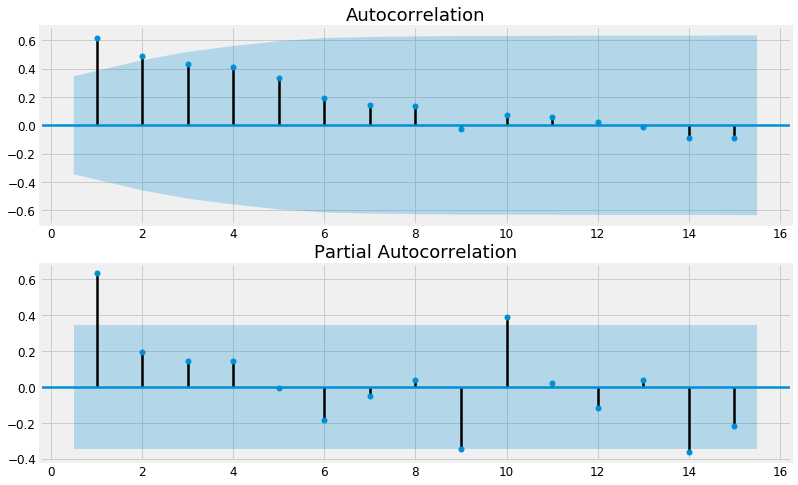

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data, lags=15, ax=ax1, zero=False)
plot_pacf(data, lags=15, ax=ax2, zero=False)
plt.show()

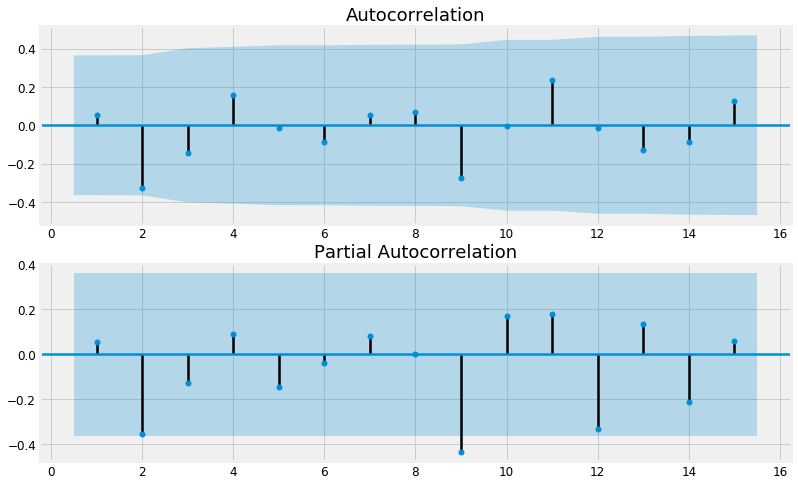

In [32]:
#Lets plot again ACF and PACF, this time detrending by substracting a moving average with a window size bigger than likely annual period.

data_detrend = data - data.rolling(4).mean()

data_detrend = data_detrend.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data_detrend, lags=15, ax=ax1, zero=False)
plot_pacf(data_detrend, lags=15, ax=ax2, zero=False)
plt.show()


### Time series decomposition

In [29]:
decomp_results = seasonal_decompose(data['Kensington_Rental_Median'])

decomp_results.plot()
plt.show()

TypeError: plot() got an unexpected keyword argument 'figsize'

##### Data decomposition comments:
• The data presents an increasing trend. I will need to differentiate.

• The data presents seasonality (yearly, 4 periods). I will test also a SARIMAX model.

## Estimation

I will look for a good model first with an ARIMA model, and then with a SARIMA model. I will the use the Akaike information criterion and the Bayesian information criterion to see how the

In [16]:
#Setting the paramenters. I am using a seasonality of 4 periods (yearly).

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

# I will combine all the paramenters and save AIC and BIC values to evaluate the models.

order_aic_bic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=True,
                          enforce_invertibility=True)
            
            results = mod.fit()
            
            order_aic_bic.append((param, param_seasonal, results.aic, results.bic))
            
            print('ARIMA{}x{}4 - AIC:{} - BIC:{} '.format(param, param_seasonal, results.aic, results.bic))
            
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:464.7186617648267 - BIC:466.18439766762646 
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:434.7819522146987 - BIC:437.7134240202982 
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:214.41631304631457 - BIC:215.7485175564898 


C:\Users\juanm\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:215.61865457512036 - BIC:218.28306359547076 
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:274.42199041051833 - BIC:277.3534622161178 


C:\Users\juanm\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:275.5914568877447 - BIC:279.98866459614385 
ARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:215.48254399587222 - BIC:218.14695301622262 
ARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:216.28651253416103 - BIC:220.28312606468666 
ARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:427.28696298128636 - BIC:430.21843478688584 
ARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:397.04016381411896 - BIC:401.4373715225181 
ARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:214.28326892265585 - BIC:216.94767794300625 
ARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:213.86305634352445 - BIC:217.85966987405007 
ARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:275.9049756923987 - BIC:280.30218340079784 
ARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:277.8689143285395 - BIC:283.7318579397384 
ARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:212.83969458258628 - BIC:216.8363081131119 
ARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:213.4937907346242 - BIC:218.82260877532502 
ARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:232.48345130957478 - BIC:233.9174385140599 
ARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:233.737763229

C:\Users\juanm\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 0, 0)x(0, 0, 1, 4)4 - AIC:250.25232753017292 - BIC:254.6495352385721 
ARIMA(1, 0, 0)x(0, 1, 0, 4)4 - AIC:213.35884130509749 - BIC:216.0232503254479 
ARIMA(1, 0, 0)x(0, 1, 1, 4)4 - AIC:211.46717931072348 - BIC:215.4637928412491 
ARIMA(1, 0, 0)x(1, 0, 0, 4)4 - AIC:249.72631637592207 - BIC:254.12352408432125 
ARIMA(1, 0, 0)x(1, 0, 1, 4)4 - AIC:250.77726194127774 - BIC:256.64020555247663 
ARIMA(1, 0, 0)x(1, 1, 0, 4)4 - AIC:209.91744957448697 - BIC:213.9140631050126 
ARIMA(1, 0, 0)x(1, 1, 1, 4)4 - AIC:210.9683851429997 - BIC:216.2972031837005 
ARIMA(1, 0, 1)x(0, 0, 0, 4)4 - AIC:242.25106363427983 - BIC:246.648271342679 
ARIMA(1, 0, 1)x(0, 0, 1, 4)4 - AIC:243.10875893308497 - BIC:248.9717025442839 
ARIMA(1, 0, 1)x(0, 1, 0, 4)4 - AIC:214.5122157287174 - BIC:218.50882925924302 
ARIMA(1, 0, 1)x(0, 1, 1, 4)4 - AIC:210.15637268317798 - BIC:215.4851907238788 
ARIMA(1, 0, 1)x(1, 0, 0, 4)4 - AIC:242.58600537937818 - BIC:248.4489489905771 


C:\Users\juanm\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 4)4 - AIC:243.88824135777895 - BIC:251.21692087177757 
ARIMA(1, 0, 1)x(1, 1, 0, 4)4 - AIC:210.32264346322108 - BIC:215.6514615039219 
ARIMA(1, 0, 1)x(1, 1, 1, 4)4 - AIC:211.7371911495998 - BIC:218.39821370047582 
ARIMA(1, 1, 0)x(0, 0, 0, 4)4 - AIC:230.1347852855297 - BIC:233.00275969449999 
ARIMA(1, 1, 0)x(0, 0, 1, 4)4 - AIC:230.74846696047578 - BIC:235.0504285739312 
ARIMA(1, 1, 0)x(0, 1, 0, 4)4 - AIC:209.84905749061684 - BIC:212.44073122262552 
ARIMA(1, 1, 0)x(0, 1, 1, 4)4 - AIC:205.6478290459192 - BIC:209.5353396439322 
ARIMA(1, 1, 0)x(1, 0, 0, 4)4 - AIC:230.0338411065951 - BIC:234.33580272005054 
ARIMA(1, 1, 0)x(1, 0, 1, 4)4 - AIC:231.39496110848887 - BIC:237.13090992642947 
ARIMA(1, 1, 0)x(1, 1, 0, 4)4 - AIC:205.3280065798086 - BIC:209.2155171778216 
ARIMA(1, 1, 0)x(1, 1, 1, 4)4 - AIC:206.57943776113268 - BIC:211.76278522515 
ARIMA(1, 1, 1)x(0, 0, 0, 4)4 - AIC:227.73593317345296 - BIC:232.0378947869084 
ARIMA(1, 1, 1)x(0, 0, 1, 4)4 - AIC:228.59210415702475

In [17]:
#Lets create a df with the information extracted to srt values and evaluate different models.

order_df = pd.DataFrame(order_aic_bic, 
                        columns=['ARIMA Parameters (p,d,q)', 'Seasonal Parameters (P,D,Q,S)', 'AIC', 'BIC'])

order_df

,"ARIMA Parameters (p,d,q)","Seasonal Parameters (P,D,Q,S)",AIC,BIC
0,"(0, 0, 0)","(0, 0, 0, 4)",464.718662,466.184398
1,"(0, 0, 0)","(0, 0, 1, 4)",434.781952,437.713424
2,"(0, 0, 0)","(0, 1, 0, 4)",214.416313,215.748518
3,"(0, 0, 0)","(0, 1, 1, 4)",215.618655,218.283064
4,"(0, 0, 0)","(1, 0, 0, 4)",274.421990,277.353462
...,...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 4)",204.149890,209.333237
60,"(1, 1, 1)","(1, 0, 0, 4)",228.040582,233.776531
61,"(1, 1, 1)","(1, 0, 1, 4)",229.230574,236.400510
62,"(1, 1, 1)","(1, 1, 0, 4)",203.867731,209.051078


### Model selection criteria
• According to bibliography, (d + D) should be less thatn 2.

• I will choose the lower AIC as it is more convenient for predictive models.

In [18]:
#top 10 models by AIC
order_df.sort_values('AIC').head(10)

,"ARIMA Parameters (p,d,q)","Seasonal Parameters (P,D,Q,S)",AIC,BIC
27,"(0, 1, 1)","(0, 1, 1, 4)",202.316196,206.203706
30,"(0, 1, 1)","(1, 1, 0, 4)",202.462696,206.350207
62,"(1, 1, 1)","(1, 1, 0, 4)",203.867731,209.051078
31,"(0, 1, 1)","(1, 1, 1, 4)",204.005126,209.188473
59,"(1, 1, 1)","(0, 1, 1, 4)",204.149890,209.333237
54,"(1, 1, 0)","(1, 1, 0, 4)",205.328007,209.215517
63,"(1, 1, 1)","(1, 1, 1, 4)",205.417168,211.896353
51,"(1, 1, 0)","(0, 1, 1, 4)",205.647829,209.535340
22,"(0, 1, 0)","(1, 1, 0, 4)",206.283940,208.875614
55,"(1, 1, 0)","(1, 1, 1, 4)",206.579438,211.762785


### The model with the best AIC is SARIMA(0,1,1)x(0,1,1)4

#### Before I fit the model and start with the diagnotic stage, I would like to try an automated way to find a SARIMAX model, using the library pmdarima, which has been imported as pm.

In [19]:
model_pm = pm.auto_arima(data,
                      seasonal=True, m=4,
                      d=1, D=1,
                      max_p=3, max_q=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(model_pm.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=213.659, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=205.328, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=202.316, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=207.142, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=204.005, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=203.719, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=202.463, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=208.133, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=204.150, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=204.139, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=205.648, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=205.918, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.3

#### The model best model by pmdarima is the same as the one previously determined: "Best model:  ARIMA(0,1,1)x(0,1,1)[4]""

## Fitting the model and Diagnostics

In [20]:
#Fitting SARIMA(0,1,1)x(0,1,1)4

model = SARIMAX(data,
                order=(0, 1, 1),
                seasonal_order=(0, 1, 1, 4))
                
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:          Kensington_Rental_Median   No. Observations:                   32
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -98.158
Date:                           Sun, 13 Sep 2020   AIC                            202.316
Time:                                   02:02:36   BIC                            206.204
Sample:                               09-30-2012   HQIC                           203.472
                                    - 06-30-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6656      0.201     -3.308      0.001      -1.060      -0.271
ma.S.L4       -0.5405      0.209     -2.585

##### Results Summary comments:
• Prob(Q) >= 0.05, thus cannot reject that residuals are uncorrelated.

• Prob(JB) >= 0.05, thus cannot reject that residuals are normally distributed.

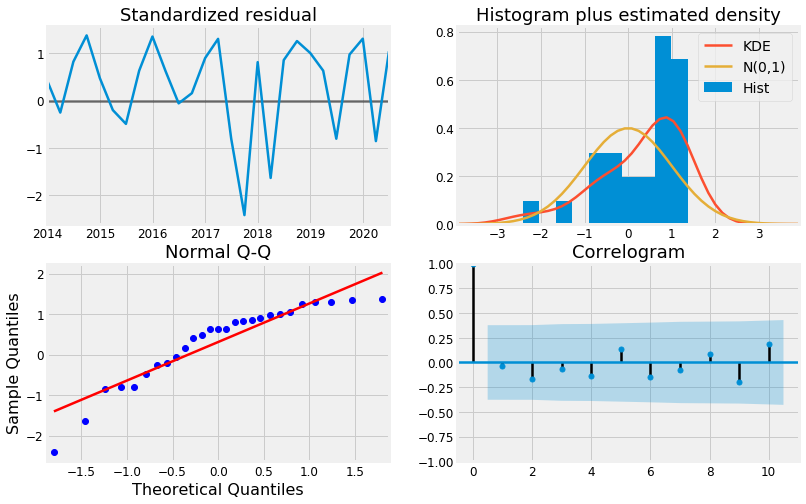

In [28]:
#Lets explore visually different diagnotics for the model

results.plot_diagnostics(figsize=(12, 8))

plt.show()

##### Diagnostic plots comments:
• The one step-head std residuals has an spike that affecs its structure.

• The histogram shows the measured distribution of the residuals. It reveals that there is a low number of samples, which affects the distribution.

• As expected from the histogram distribution and its difference from the normal distribution, the Normal Q-Q presents some deviations.

• The Correlogram shows no significant correlation between the residuals.

### Spliting the data into train and test

Before I move forward to production and forecasting, I want to test the model on train data to see how it will predict the test data. There are 32 quarters from 30/09/2012 to 30/06/2020. I will aim for a 80/20 split, thus I will train the model with data from 30/09/2012 to 30/09/2018 and leave 7 quarters to test.

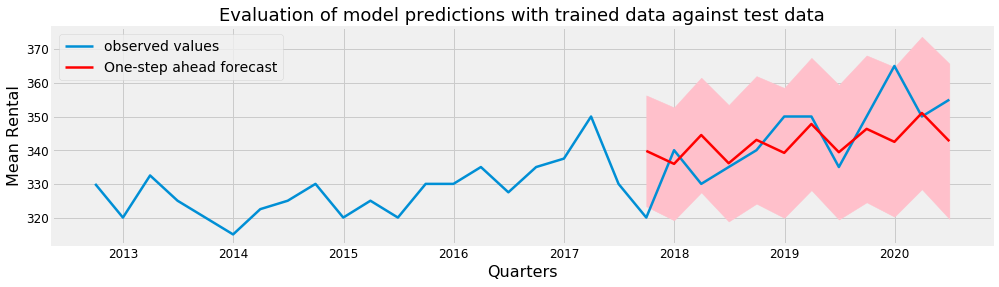

In [22]:
data_train = data[:'2018-09']
data_test = data['2018-12':]

model_train = SARIMAX(data_train,
                order=(0, 1, 1),
                seasonal_order=(0, 1, 1, 4))
                
results = model_train.fit()

one_step_forecast = results.get_prediction(start='2017-09-30', end='2020-06-30', dynamic=True)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Kensington_Rental_Median']
upper_limits = confidence_intervals.loc[:,'upper Kensington_Rental_Median']

plt.figure(figsize=(14,5))

plt.plot(data.index, data, label='observed values')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='One-step ahead forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.title('Evaluation of model predictions with trained data against test data')
plt.xlabel('Quarters')
plt.ylabel('Mean Rental')
plt.legend()
plt.show()

### Validating with testing forecast

Now I will compare the predicted mean with the observed mean, for the test data. The model has not seen this data. I will calculate the Mean Squared Error and the Root Mean Squared Error.

In [23]:
mean_rental_obs = data_test
mse = (data_test['Kensington_Rental_Median'].subtract(mean_forecast['2018-12-31':][0], axis=0) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 199.75
The Root Mean Squared Error of our forecasts is 14.13


## Production

Now I will be using the whole data to train the model, evaluate in-sample predictions and out of sample forecast. 

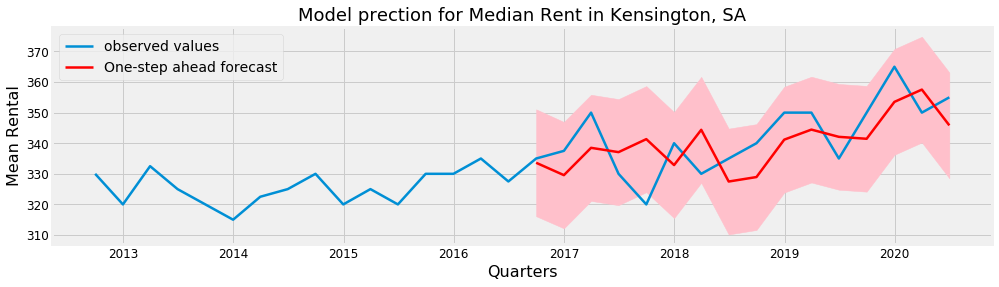

In [24]:
model = SARIMAX(data,
                order=(0, 1, 1),
                seasonal_order=(0, 1, 1, 4))

results = model.fit()

pred = results.get_prediction(start='2016-09-30')

mean_prediction = pred.predicted_mean

confidence_intervals = pred.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Kensington_Rental_Median']
upper_limits = confidence_intervals.loc[:,'upper Kensington_Rental_Median']

plt.figure(figsize=(14,5))

plt.plot(data.index, data, label='observed values')

plt.plot(mean_prediction.index, mean_prediction, color='r', label='One-step ahead forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.title('Model prection for Median Rent in Kensington, SA')
plt.xlabel('Quarters')
plt.ylabel('Mean Rental')
plt.legend()
plt.show()

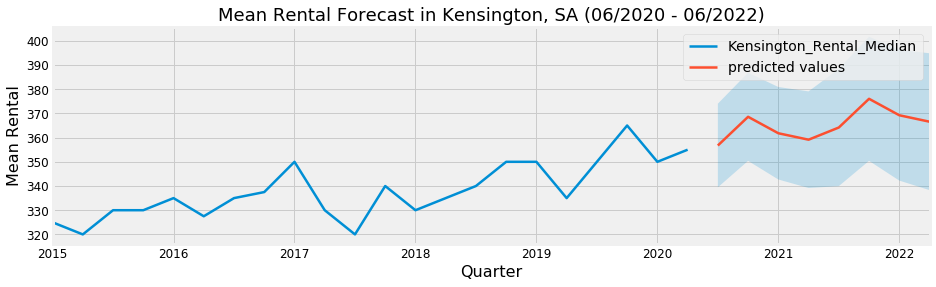

In [25]:
#Forecast

forecast_object = results.get_forecast(steps=8)

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

fig, ax = plt.subplots(figsize=(14,5))

data['2015':].plot(label='past observations', ax=ax)

mean.plot(label='predicted values', ax=ax)

ax.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)


# Plot legend and show figure
ax.set_xlabel('Quarter')
ax.set_ylabel('Mean Rental')
plt.title('Mean Rental Forecast in Kensington, SA (06/2020 - 06/2022)')
plt.legend()
plt.show()